In [1]:

import numpy as np
from scipy.optimize import milp, LinearConstraint, Bounds, OptimizeResult
from typing import List
import matplotlib.pyplot as plt
import csv

In [2]:
from baconshor import *

In [3]:
def mle_decoder_bs(M : int, 
                I : List[List[int]],
                C : List[int],
                p : List[float] | float) -> OptimizeResult:
    """
    Solves the MLE decoder problem using a MILP solver.

    Parameters:
        - M: Number of binary variables E_j.
        - I: List of lists. I[i] is the set of errors E_j which flip the check C_i
        - C: Constraint values C_i.
        - p: List of probabilities p_j for each E_j.

    Returns:
        - result: The result object from scipy.optimize.milp.
        
    """
    # Validate input data
    N = len(I)
    assert len(C) == N, "Length of C must be N"

    if np.isscalar(p):
        p = [p] * M
    elif type(p) is List:
        assert len(p) == M, "Length of p must be M"
    else:
        raise ValueError('p must be a float or a list of floats')

    # Idea: The decision variable x contains both E_j and K_i values.
    # i.e. x = [E_1, ..., E_M, K_1, ..., K_N]
    # The scipy milp solver minimizes <c, x> where c is the objective function coefficients. 
    # We can ignore the constant log(1-p_j) in the objective function.

    # Construct the objective function coefficients, by default set the K_i coefficients to zero
    # Note the minus sign for the E_i coeffs because the solver minimizes the objective function
    c = np.array([-np.log(p_j) + np.log(1 - p_j) for p_j in p] + [0]*N) 

    # Construct equality constraints matrix (constraints are Ax = b)
    A_eq = np.zeros((N, M + N)) # N constraints, (M + N) variables
    b_eq = []
    for i in range(N):

        # Constraint for the check, C_i is: \sum_{Ej in I_i} E_j - 2K_i = (1 - C_i)/2
        # where I_i is the set of errors [...,E_j,...] that flip the check C_i
        
        # Firstly, set the matrix elements to pick out the appropriate E_j values
        for j in I[i]:
            if j >= M:
                raise ValueError(f"E_j index {j} exceeds M-1")
            A_eq[i, j] = 1

        # Next, set matrix elements to pick out the corresponding K_i
        A_eq[i, M + i] = -2

        # Lastly, compute the right-hand side (1 - C_i)/2
        b_eq.append((1 - C[i]) / 2)

    # Define constraints (equality constraints)
    constraints = LinearConstraint(A=A_eq, lb=b_eq, ub=b_eq)

    # Bounds: E_j: binary (0-1), K_i: integer >=0
    bounds = Bounds(lb = [0]*M + [0]*N,
                    ub = [1]*M + [np.inf]*N)

    # Integrality: Both E_j and K_i are integers within bounds (i.e. 1)
    integrality = [1]*(M + N)  

    # Solve the MILP
    res = milp(c           = c,
               constraints = constraints,
               integrality = integrality,
               bounds      = bounds)
    
    return M, N, res

def Print_result(M,N,result):
    guess = []
    if result.success:
        print("Optimization successful.")
        print(">> Maximum objective value:", -result.fun)  # Convert back to maximization
        print(">> Optimal E_j values:")
        for j in range(M):
            print(f"\t E_{j+1} = {round(result.x[j])}")
            guess.append(round(result.x[j]))
        print(">> Optimal K_i values:")
        for i in range(N):
            print(f"\t K_{i+1} = {int(result.x[M + i])}")
    else:
        print("No optimal solution found.")
        print("Status:", result.message)
        print("Details:", result.get("message", "No additional information"))

    return guess

def print_result(M,N,result):
    guess = []
    if result.success:
        # print("Optimization successful.")
        # print(">> Maximum objective value:", -result.fun)  # Convert back to maximization
        # print(">> Optimal E_j values:")
        for j in range(M):
            # print(f"\t E_{j+1} = {round(result.x[j])}")
            guess.append(round(result.x[j]))
        # print(">> Optimal K_i values:")
        # for i in range(N):
        #     print(f"\t K_{i+1} = {int(result.x[M + i])}")
    else:
        print("No optimal solution found.")
        # print("Status:", result.message)
        # print("Details:", result.get("message", "No additional information"))

    return guess

Testing stabilizers on bs for x errors

In [4]:
M = 3
grid = create_grid(3)
Print(grid)
add_y_error(grid,[5,9])#pretend this is an x error not y error
print("Added error on the  5th and 9th qubit:")#Assumes positions are given such that the topleft number is 
Print(grid)
construct_stabilizers_scipy_x_errors(M, grid)

0 0 0 
0 0 0 
0 0 0 
Added error on the  5th and 9th qubit:
0 0 0 
0 1 0 
0 0 1 


([[0, 3, 1, 4, 2, 5], [3, 6, 4, 7, 5, 8]], [-1, 1])

Testing decoder for x errors

In [7]:
# Set up for the code
M = 3
grid = create_grid(3)# no error
print("Error grid:")
add_y_error(grid,[1,9])
Print(grid)
I, C = construct_stabilizers_scipy_x_errors(M,grid)

# Particular syndrome measurement
p = 0.5

# expected_E = [1,0,0]
# print('Expected E_j values')
# for j in range(M):
#     print(f'\t E_{j} = {expected_E[j]}')
# print()
# mle_decoder_bs(M**2,I,C,p)
guess = print_result(*mle_decoder_bs(M**2,I,C,p))
print("Decoder made this guess:")
Print(solver_to_grid_scipy(3,guess))
print("Was the decoder right?:")
solver_accuracy_x_errors(3,grid,solver_to_grid_scipy(M,guess))

Error grid:
1 0 0 
0 0 0 
0 0 1 
Decoder made this guess:
0 0 1 
0 0 0 
0 0 1 
Was the decoder right?:


True

In [13]:
# Set up for the code
M = 5
grid = create_grid(5)# no error
print("Error grid:")
add_y_error(grid,[1,6,11])
Print(grid)
I, C = construct_stabilizers_scipy_x_errors(M,grid)

# Particular syndrome measurement
p = 0.4

# expected_E = [1,0,0]
# print('Expected E_j values')
# for j in range(M):
#     print(f'\t E_{j} = {expected_E[j]}')
# print()
# mle_decoder_bs(M**2,I,C,p)
guess = print_result(*mle_decoder_bs(M**2,I,C,p))
print("Decoder made this guess:")
Print(solver_to_grid_scipy(M,guess))
print("Was the decoder right?:")
solver_accuracy_x_errors(M,grid,solver_to_grid_scipy(M,guess))

Error grid:
1 0 0 0 0 
1 0 0 0 0 
1 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
Decoder made this guess:
0 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
0 0 0 0 1 
0 0 0 0 1 
Was the decoder right?:


False

In [14]:
# Set up for the code
M = 7
print("Error grid:")
p = 0.1
grid = random_error_grid(M,p)
Print(grid)
I, C = construct_stabilizers_scipy_x_errors(M,grid)




# expected_E = [1,0,0]
# print('Expected E_j values')
# for j in range(M):
#     print(f'\t E_{j} = {expected_E[j]}')
# print()
# mle_decoder_bs(M**2,I,C,p)
guess = print_result(*mle_decoder_bs(M**2,I,C,p))
print("Decoder made this guess:")
Print(solver_to_grid_scipy(M,guess))
print("Was the decoder right?:")
solver_accuracy_x_errors(M,grid,solver_to_grid_scipy(M,guess))

Error grid:
1 1 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 1 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
Decoder made this guess:
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 1 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
0 0 0 0 0 0 0 
Was the decoder right?:


True

In [17]:
M=3
physical_error_probs = np.linspace(0.01, 0.50, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(2000):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy_x_errors(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy_x_errors(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/2000)
phys_three = physical_error_probs
log_three = logical_error_probs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


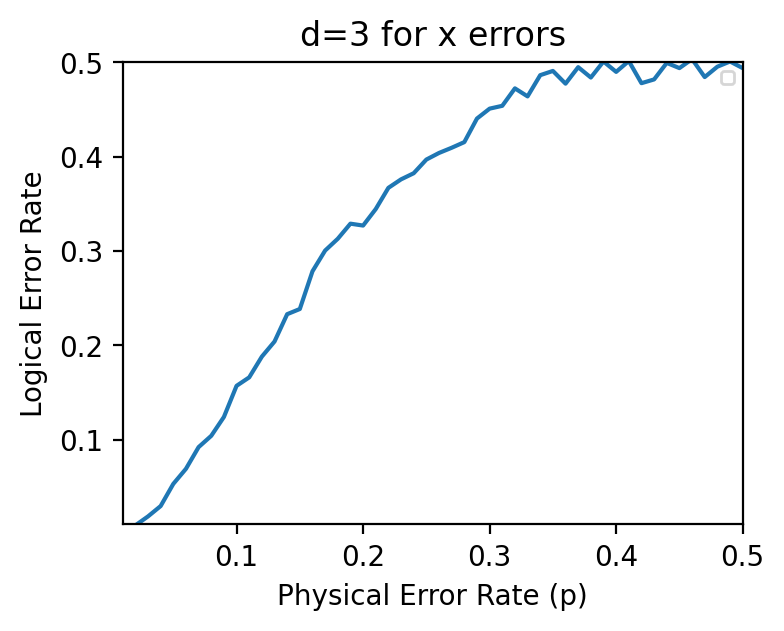

In [18]:
plot(phys_three, log_three, 0.01, 0.5, "d=3 for x errors", None)

In [16]:
M=5
physical_error_probs = np.linspace(0.01, 0.50, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(2000):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy_x_errors(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy_x_errors(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/2000)
phys_five = physical_error_probs
log_five = logical_error_probs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


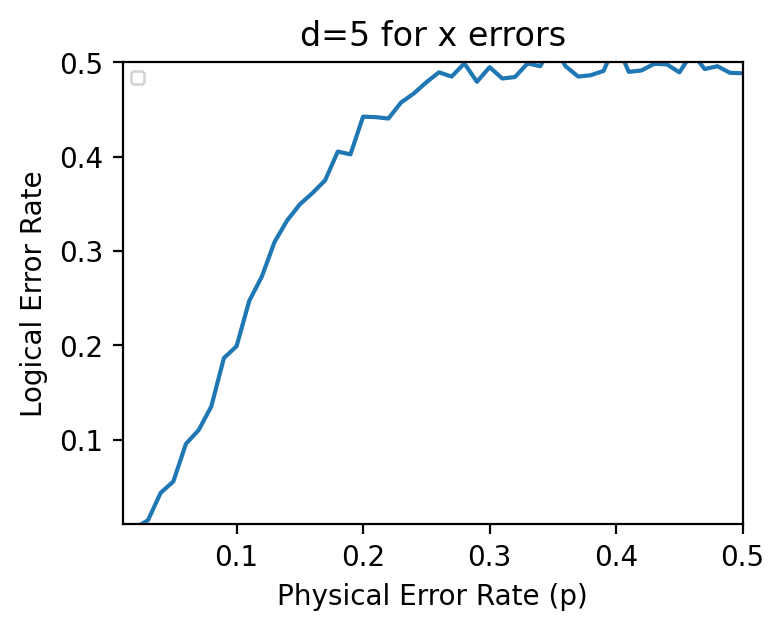

In [22]:
plot(phys_five, log_five, 0.01, 0.5, "d=5 for x errors", None)

In [20]:
M=7
physical_error_probs = np.linspace(0.01, 0.50, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(2000):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy_x_errors(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy_x_errors(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/2000)
phys_seven = physical_error_probs
log_seven = logical_error_probs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


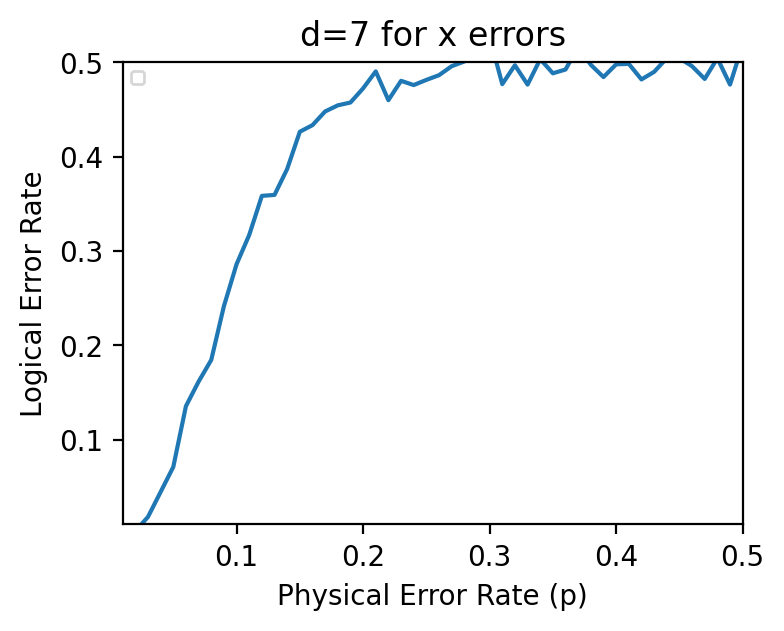

In [21]:
plot(phys_seven, log_seven, 0.01, 0.5, "d=7 for x errors", None)

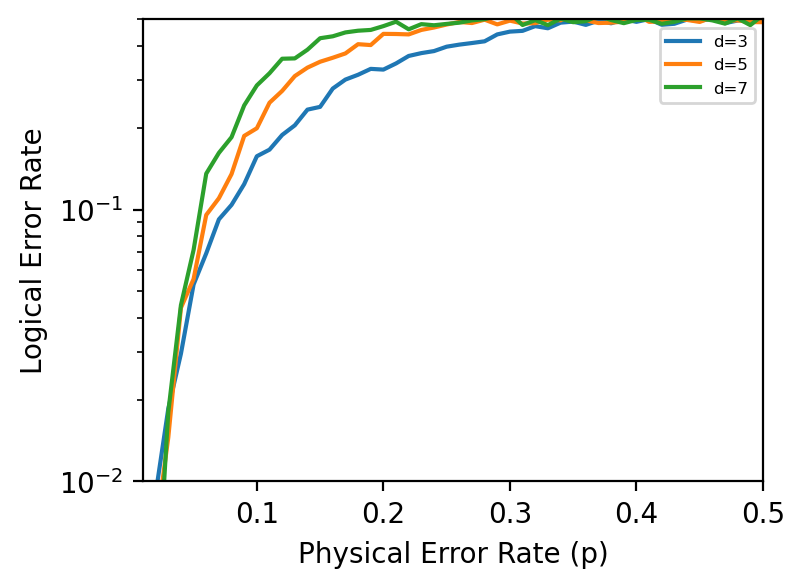

In [23]:
plot_multiple([3,5,7],phys_three,[log_three,log_five,log_seven],0.01,0.5,"d-3,5,7 for x errors", None)

In [37]:
M=3
physical_error_probs = np.linspace(0.04, 0.15, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(5000):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy_x_errors(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy_x_errors(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/5000)
phys_three = physical_error_probs
log_three = logical_error_probs

In [38]:
M=5
physical_error_probs = np.linspace(0.04, 0.15, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(5000):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy_x_errors(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy_x_errors(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/5000)
phys_five = physical_error_probs
log_five = logical_error_probs

In [39]:
M=7
physical_error_probs = np.linspace(0.04, 0.15, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(5000):
        grid = random_error_grid(M,p)
        I, C = construct_stabilizers_scipy_x_errors(M,grid)
        guess = print_result(*mle_decoder_bs(M**2,I,C,p))
        if(solver_accuracy_x_errors(M,grid,solver_to_grid_scipy(M,guess)) != True):
            count+=1
    logical_error_probs.append(count/5000)
phys_seven = physical_error_probs
log_seven = logical_error_probs

Text(0.5, 1.0, ' smaller plot for d=3,5,7 for x errors')

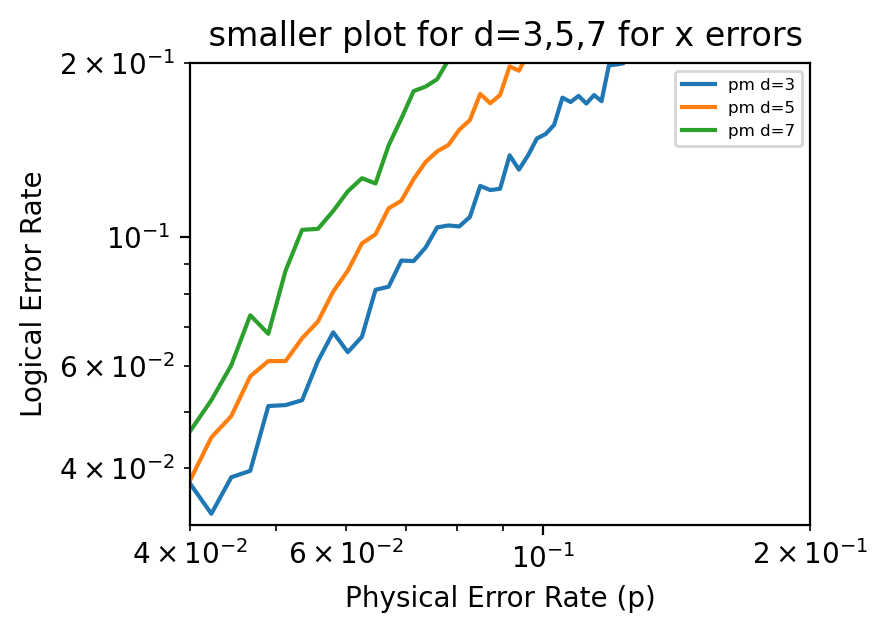

In [47]:
fig,ax = plt.subplots(1,1,dpi=200,figsize = (4,3))

for d, log in zip([3,5,7], [log_three,log_five,log_seven]):
    # if d == 9:
    ax.plot(phys_three, log, label=f"pm d={d}")
ax.legend(fontsize=6)
ax.set_ylim(0.032, 0.2)
ax.set_xlim(0.04, 0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Physical Error Rate (p)")
ax.set_ylabel("Logical Error Rate")
plt.title(" smaller plot for d=3,5,7 for x errors")